In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (20, 4)

import math, itertools
import numpy as np

from CubeView import CubeView
from CfopCube import CfopCube, CROSS, F2L, OLL, PLL
from CyclicSolver import CyclicSolver
from FaceletSolver import FaceletSolver

from VectorCube import color_name, WHITE_CB, ORANGE_CB, GREEN_CB, RED_CB, BLUE_CB, YELLOW_CB

Cycle period turns: 1896 in range: [12, 315], unique: [12, 15, 24, 30, 60, 75, 90, 105, 126, 180, 210, 270, 315] avg: 128.35443037974684


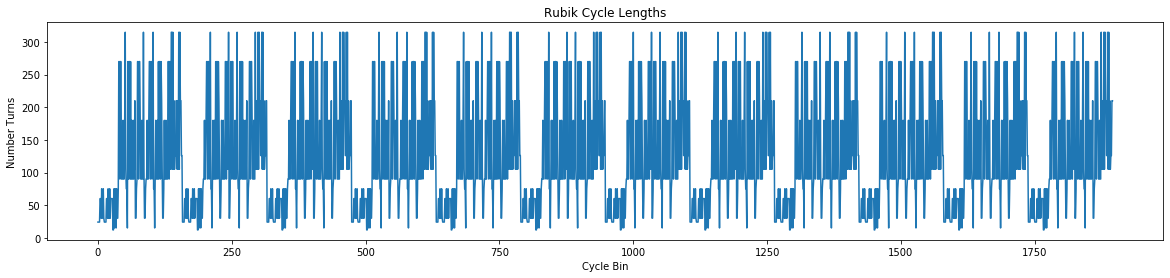

In [6]:
cube = CfopCube()
csolver = CyclicSolver()

def cycle_solved(cube, moves):
#{
    for i, mv in enumerate(moves):
        if cube.rotate(mv).is_solved(): return True, (i+1)
    
    return False, len(moves)
#}

idx = 0
nturns = []
MAX_TURNS = 1000
for cymoves in csolver.gen_rhythmic_cycles():
#{
#     if len(nturns) > 250: break

    solved, turns = False, 0
    while (turns < MAX_TURNS) and not solved:
        solved, ctns = cycle_solved(cube, cymoves)
        turns += ctns
        
#         if solved and turns < 10: idx += 1; print(f'{idx}: ({turns}) {cy}')
    
    nturns.append(turns)
#}

plt.figure(1)
plt.plot(nturns)
plt.title(f'Rubik Cycle Lengths')
plt.ylabel('Number Turns')
plt.xlabel('Cycle Bin')

print(f"Cycle period turns: {len(nturns)} in range:",
      f"[{np.amin(nturns)}, {np.amax(nturns)}],",
      f"unique: {sorted(set(nturns))} avg: {np.average(nturns)}")

In [ ]:
cysolver = CyclicSolver()

def facelet_flips(cube, moves, flips):
#{
    for i, mv in enumerate(moves):
    #{
        idx = CfopCube._movableindex
        nhomelist = sum(cube.rotate(mv).compare(flet_index=idx)) != 3
        
        flipcount = sum(nhomelist)
        if (flipcount > 0) and (flipcount <= 16): flips.append(flipcount)
    #}
    
    return flips
#}

flips = []
for cymoves in cysolver.generate_move_cycles():
#{
    solve_cube = CfopCube()
    flip_cube = CfopCube()

    solved = False
    while not solved:
        solved, ctns = cycle_solved(solve_cube, cymoves)
        flips = facelet_flips(flip_cube, cymoves, flips)
#}

plt.figure(1)
plt.plot(flips)
plt.title(f'Rubik\'s Scramble Measure')
plt.ylabel('Number Unsolved Facelets')
plt.xlabel('Moves')

print(f"Cycle scramble measure numb: {len(flips)} in range:",
      f"[{np.amin(flips)}, {np.amax(flips)}],",
      f"unique: {set(flips)} avg: {np.average(flips)}")

In [ ]:
cysolver = CyclicSolver()
fsolver = FaceletSolver()
sequences = fsolver.create_sequence_hash(wildcard=True)
heuristic_hash = fsolver.create_heuristic_hash(sequences)

In [ ]:
solved_cube = CfopCube()
cfop_cube = CfopCube().scramble(sz=20)
CubeView(cfop_cube).draw_projection()

In [ ]:
cyctics, s_cyctics = [], []
index = np.random.randint(0, len(cysolver.cycles))
for i, (cymoves, period) in enumerate(zip(cysolver.cycles, cysolver.periods)):
#{
    if i == index:
        print(index, ":", cymoves, ":", period)
        cycube = CfopCube(cfop_cube)
        s_cycube = CfopCube(solved_cube)
        
        cyctics.append(fsolver.heuristic(cycube))
        s_cyctics.append(fsolver.heuristic(s_cycube))
        cyctics.extend([fsolver.heuristic(cycube.rotate(cymoves[i%len(cymoves)])) for i in range(period)])
        s_cyctics.extend([fsolver.heuristic(s_cycube.rotate(cymoves[i%len(cymoves)])) for i in range(period)])      
#}

plt.figure(1)
plt.plot(cyctics)
plt.plot(s_cyctics)
plt.title(f'Rubik\'s Cycling Heuristics')
plt.ylabel('Heuristic Value')
plt.xlabel('Move Number')

In [ ]:

# np.amin(cyruistics[0])
# np.argwhere(cyruistics[0] == np.amin(cyruistics[0])).flatten()[0]

In [ ]:
print(fsolver.heuristic(cfop_cube))
h = [(np.amin(values), np.argwhere(values == np.amin(values)).flatten()[0]) for values in cyruistics]
# print(h)

In [ ]:
# list(itertools.permutations(np.array([1, 2, 3])))

index = np.array([1,3,5,7])
cube = CfopCube().scramble(sz=2)
CubeView(cube).draw_projection()

print("Facelets solved:", sum(sum(cube.facelet_matrix[2:, index] == CfopCube._facelet_matrix[2:, index]) == 3))

# solved = 
sum(sum(cube.facelet_matrix[2:, index] == CfopCube._facelet_matrix[2:, index])) == (3*index.shape[0])

In [ ]:
class UCCyclicNode:
#{
    UCTFACTOR = math.sqrt(2.0)
    
    total_visits = 0
    total_nodes = 0
    move_depth = 0
    
    # These for derivation of incremental mean 
    # and standard deviation of heuristic values
    mu_h = 0
    sn_h = 0
    sigma_h = 0
    n = 0
        
    @classmethod
    def update_sigma(cls, heuristic):
    #{
        cls.n += 1
        mu_prev = cls.mu_h
        sn_prev = cls.sn_h
        
        cls.mu_h = mu_prev + ((heuristic - mu_prev) / cls.n)
        cls.sn_h = sn_prev + ((heuristic - mu_prev) * (heuristic - cls.mu_h))
        cls.sigma_h = math.sqrt(cls.sn_h/cls.n)
    #}

    @classmethod
    def reset_tree(cls):
    #{
        cls.total_visits = 0
        cls.total_nodes = 0
        cls.move_depth = 0
    #}
        
    def __init__(self, heuristic, move=None, parent=None):
    #{
        # Move that produces this node/cube state
        self.move = move
        
        # Note: heuristic will be in [-48, 224], thus a
        # scaling factor applied to map to ~(0.0, 7.0]
        self.heuristic = (162 - heuristic) / 30.0
        UCTNode.update_sigma(self.heuristic)
        
        self.numb_visits = 0
        self.child_nodes = []
        self.parent_node = parent
        
        UCTNode.total_nodes += 1
    #}
    
    def __repr__(self):
        return (f"Move:    {self.move}\n"
                f"Visits:  {self.numb_visits}\n"
                f"Value:   {self.heuristic})")
    
    def set_root(self):
        self.move = None
        self.parent_node = None
        return self
        
    def ucbonus(self):
    #{
        # Calc uncertainty bonus
        exploit = (1 + self.numb_visits)
        explore = np.log(self.parent_node.numb_visits)
        return UCTNode.UCTFACTOR * math.sqrt(explore/exploit)
    #}

    def select_uct_child(self):
        return max(self.child_nodes, key=lambda cld: cld.heuristic + cld.ucbonus())
    
    def get_uct_children(self):
        return sorted(self.child_nodes, key=lambda cld: cld.heuristic + cld.ucbonus())
    
    def select_mvp_child(self, mvp=None, depth=0):
    #{
        depth += 1 # Depth here is just for algorithm diagnosics 
        if depth > UCTNode.move_depth: UCTNode.move_depth = depth

        for child in self.child_nodes: mvp = child.select_mvp_child(mvp, depth)
        if (mvp is None) or (self.heuristic > mvp.heuristic): mvp = self
        return mvp
    #}
    
    def add_child(self, heuristic, move):
    #{
        child = UCTNode(heuristic, move=move, parent=self)
        self.child_nodes.append(child)
        return child
    #}
    
    def update(self):
        self.numb_visits += 1
        UCTNode.total_visits += 1
#}

In [ ]:
import random, re, time
from IPython.display import clear_output

class CyclicTreeSearch:
#{
    ref_moves = None
    prnt_time = time.time()
    
    @staticmethod
    def output_status(node_path_list):
    #{
        if (time.time() - TreeSolver.prnt_time) > 1.0:
        #{            
            output_string = ''
            for depth, node in enumerate(node_path_list):
            #{
                curr_move_str = FaceletSolver.path_str([node.move]) if node.move else 'root'
                reference_move = TreeSolver.ref_moves[depth] if depth < len(TreeSolver.ref_moves) else []

                move_options, found, index = '[', False, -1
                for idx, child in enumerate(node.get_uct_children()):
                #{
                    if reference_move: found = (reference_move == child.move)
                    if idx < 5: move_options += f'{FaceletSolver.path_str([child.move])}:{child.ucbonus()}/{child.value()}, '
                    if found: index = idx; break
                #}
                
                move_options = re.sub(r', $', ']', move_options)
                ref_move_str = FaceletSolver.path_str([reference_move]) if reference_move else 'past'
                if not found: output_string += (f'[{curr_move_str}]: {ref_move_str}, NOT found in {len(node.child_nodes)} moves: {move_options}\n')
                else: output_string += (f'[{curr_move_str}]: {ref_move_str}, found at {index} of {len(node.child_nodes)}: {move_options}\n')
            #}
            
            clear_output(wait=True)
            print(output_string)
            TreeSolver.prnt_time = time.time()
        #}
    #}
    
    @staticmethod
    def output_state_progress(solved, fsolver, cfop_cube, moves):
    #{
        print(f"\nSolved cube: {solved}, Numb moves to best node: {len(moves)}, moves: {moves}\n")

        view = CubeView(cfop_cube)
        for depth, mv in enumerate(moves):
        #{
            cfop_cube.rotate(mv)
            if((len(moves) - depth+1) < 20):
                value = fsolver.heuristic(cfop_cube)
                view.push_snapshot(caption=f"{color_name(mv[0])} ({mv[1]}) : {value}")
        #}

        if len(moves): view.draw_snapshops()
        return cfop_cube
    #}
    
    @staticmethod
    def cyclic_tree_search(fsolver, cysolver, cfop_cube):
    #{
#         solve_state = SolveState(fsolver)
        rootnode = UCCyclicNode(fsolver.heuristic(cfop_cube))
        solved, node = TreeSolver.uc_tree_search(cfop_cube, rootnode, fsolver, cysolver)
        moves = TreeSolver.get_move_sequence(node)
    
        cfop_cube = TreeSolver.output_state_progress(solved, fsolver, cfop_cube, moves)
        
#         while solved and (solve_state.increment_state() != 'Done'):
#         #{
#             solved, node = TreeSolver.uc_tree_search(cfop_cube, node.set_root(), solve_state)
#             state_moves = TreeSolver.get_move_sequence(node)
#             moves.extend(state_moves)
            
#             cfop_cube = TreeSolver.output_state_progress(solved, solve_state, cfop_cube, state_moves)
#         #}
        
        if not solved: print("Maximum depth searched:", UCCyclicNode.move_depth)
        return solved, moves, solve_state 
    #}
    
    @staticmethod
    def is_redundant_move(node, move):
        # Aka: is-back-to-back-rotation-of-same-side
        return node.move and (node.move[0] == move[0])

    @staticmethod
    def uc_tree_search(cfop_cube, rootnode, fsolver, cysolver, max_moves=100, iterations=50000):
    #{
#         # Init CFOP speedcuber algorithm
#         TreeSolver._update_cfop(rootnode)

#         # Catches anomoly of uc_tree_search called on already stage-solved cube
#         if solve_state.is_complete(solve_state.heuristic(cfop_cube)): return True, rootnode
    
        # UCT loop (w/o MC rollout)
        for i in range(iterations):
        #{
            node = rootnode
            cube = CfopCube(cfop_cube)
            UCCyclicNode.move_depth = 0
            
            # SELECT (down to a leaf node on frontier)
            node_path_debug = [node]
            while node.child_nodes:
                node = node.select_uct_child()
                cube.rotate(node.move)
                UCCyclicNode.move_depth += 1
                node_path_debug.append(node)
            
            # Print algorithm status
            # TreeSolver.output_status(node_path_debug)
            
            # EXPAND (adds some subset of the 18 possible rotations)
            if UCCyclicNode.move_depth < max_moves:
            #{                
                for move in solve_state.expand_moves(cube):
                #{
                    if not TreeSolver.is_redundant_move(node, move):
                        heuristic = solve_state.heuristic(CfopCube(cube).rotate(move))
                        child_node = node.add_child(heuristic, move)
                        if solve_state.is_complete(heuristic):
                            return True, child_node
                #}

                # Descend (one step, no real ROLLOUT)
                node = random.choice(node.child_nodes)
            #}
            
            # BACKTRACK
            while node:
                node.update()
                node = node.parent_node
        #}
        
        return False, rootnode.select_mvp_child()
    #}
    
    @staticmethod
    def get_move_sequence(leaf_node):
    #{
        moves = []
        while leaf_node:
        #{
            if leaf_node.move: moves.append(leaf_node.move)
            leaf_node = leaf_node.parent_node
        #}  
        
        moves.reverse()
        return moves
    #}
#}

In [ ]:
class CfopState:
#{
    state_queue = [CROSS, 'Done', F2L, OLL, PLL]
    
    def __init__(self):
        self.state = SolveState.state_queue[0]
    
    def increment_state(self):
    #{
        idx = next(i for i, state in enumerate(CfopState.state_queue) if self.state == state)
        self.state = self.state_queue[idx+1]
        return self.state
    #}
    
    def is_complete(self, cube):
    #{
        state_idx = self.flet_index()
        logical_eq = cube.facelet_matrix[2:, state_idx] == \
                     CfopCube._facelet_matrix[2:, state_idx]
        return sum(sum(logical_eq)) == (state_idx.shape[0] * 3)
    #}
    
    def value(self, cube, child_cube):    
    #{
        state_idx = self.flet_index()
        logical_eq = cube.facelet_matrix[2:, state_idx] == \
                     CfopCube._facelet_matrix[2:, state_idx]
        return sum(sum(logical_eq) == 3)
    #}
    
    def max_depth(self): return 10
    
    def flet_index(self, color=WHITE_CB):
        return CfopCube._cfop[(self.state, color)]
            
    def expand_moves(self, cube): return CfopCube.MOVES
#         return self.fsolver.restricted_moves(opticube, self.flet_index())
#}

In [ ]:
class CfopNode:
#{
    UCTFACTOR = math.sqrt(2.0)
    
    total_visits = 0
    total_nodes = 0
    move_depth = 0
    
    # These for derivation of incremental mean 
    # and standard deviation of heuristic values
    mu_h = 0
    sn_h = 0
    sigma_h = 0
    n = 0
        
    @classmethod
    def update_sigma(cls, heuristic):
    #{
        cls.n += 1
        mu_prev = cls.mu_h
        sn_prev = cls.sn_h
        
        cls.mu_h = mu_prev + ((heuristic - mu_prev) / cls.n)
        cls.sn_h = sn_prev + ((heuristic - mu_prev) * (heuristic - cls.mu_h))
        cls.sigma_h = math.sqrt(cls.sn_h/cls.n)
    #}

    @classmethod
    def reset_tree(cls):
    #{
        cls.total_visits = 0
        cls.total_nodes = 0
        cls.move_depth = 0
    #}
        
    def __init__(self, move=None, value=None, parent=None):
    #{
        # Move that produces this node/cube state
        # and the corresponding value of that move
        self.move = move 
        self.value = value
        
        self.numb_visits = 0
        self.child_nodes = []
        self.parent_node = parent
        
        CfopNode.total_nodes += 1
        CfopNode.update_sigma(self.value)
    #}
    
    def __repr__(self):
        return (f"Move:    {self.move}\n"
                f"Visits:  {self.numb_visits}\n"
                f"Value:   {self.value})")
    
    def set_root(self):
        self.move = None
        self.parent_node = None
        return self
    
    def ucbonus(self):
    #{
        # Calc uncertainty bonus
        exploit = (1 + self.numb_visits)
        explore = np.log(self.parent_node.numb_visits)
        return CfopNode.UCTFACTOR * math.sqrt(explore/exploit)
    #}
    
    def select_uct_child(self):
        return max(self.child_nodes, key=lambda child: child.value + child.ucbonus())
    
    def get_uct_children(self):
        return sorted(self.child_nodes, key=lambda child: child.value + child.ucbonus())
    
    def select_mvp_child(self, mvp=None, depth=0):
    #{
        depth += 1 # Depth here is just for algorithm diagnosics 
        if depth > CfopNode.move_depth: CfopNode.move_depth = depth

        for child in self.child_nodes: mvp = child.select_mvp_child(mvp, depth)
        if (mvp is None) or (self.value > mvp.value): mvp = self
        return mvp
    #}
    
    def add_child(self, move, value):
    #{
        child = CfopNode(move=move, value=value, parent=self)
        self.child_nodes.append(child)
        return child
    #}
    
    def update(self):
        self.numb_visits += 1
        CfopNode.total_visits += 1
#}

In [ ]:
import random, re, time
from IPython.display import clear_output

class CfopSolver:
#{
    ref_moves = None
    prnt_time = time.time()
    
    @staticmethod
    def output_state_progress(solved, solve_state, cfop_cube, moves):
    #{
        print(f"\nSolved state \'{solve_state.state}\': {solved}")
        print(f"  Numb moves to best node: {len(moves)}, moves: {moves}\n")

        view = CubeView(cfop_cube)
        for depth, mv in enumerate(moves):
        #{
            cfop_cube.rotate(mv)
            if((len(moves) - depth+1) < 20):
                value = solve_state.value(cfop_cube)
                view.push_snapshot(caption=f"{color_name(mv[0])} ({mv[1]}) : {value}")
        #}

        if len(moves): view.draw_snapshops()
        return cfop_cube
    #}
    
    @staticmethod
    def state_tree_search(cfop_cube):
    #{
        rootnode = CfopNode()
        solve_state = SolveState()
        solved, node = CfopSolver.uc_tree_search(cfop_cube, rootnode, solve_state)
        moves = CfopSolver.get_move_sequence(node)
    
        cfop_cube = CfopSolver.output_state_progress(solved, solve_state, cfop_cube, moves)
        
        while solved and (solve_state.increment_state() != 'Done'):
        #{
            solved, node = CfopSolver.uc_tree_search(cfop_cube, node.set_root(), solve_state)
            state_moves = CfopSolver.get_move_sequence(node)
            moves.extend(state_moves)
            
            cfop_cube = CfopSolver.output_state_progress(solved, solve_state, cfop_cube, state_moves)
        #}
        
        if not solved: print("Maximum depth searched:", CfopNode.move_depth)
        return solved, moves, solve_state 
    #}
    
    @staticmethod
    def is_redundant_move(node, move):
        # Aka: is-back-to-back-rotation-of-same-side
        return node.move and (node.move[0] == move[0])

    @staticmethod
    def uc_tree_search(cfop_cube, rootnode, solve_state, iterations=50000):
    #{
        # Catch anomoly of uc_tree_search call on stage-solved cube
        if solve_state.is_complete(cfop_cube): return True, rootnode
    
        # UCT loop (w/o MC rollout)
        for i in range(iterations):
        #{
            node = rootnode
            cube = CfopCube(cfop_cube)
            CfopNode.move_depth = 0
            
            # SELECT (down to a leaf node on frontier)
            # node_path_debug = [node]
            while node.child_nodes:
                node = node.select_uct_child()
                cube.rotate(node.move)
                CfopNode.move_depth += 1
                # node_path_debug.append(node)
            
            # Print algorithm status
            # CfopSolver.output_status(node_path_debug)
            
            # EXPAND (some subset of the 18 possible rotations)
            if CfopNode.move_depth < solve_state.max_depth():
            #{
                for move in CfopCube.MOVES:
                #{
                    if not CfopSolver.is_redundant_move(node, move):
                        child_cube = CfopCube(cube).rotate(move)
                        value = solve_state.value(cube, child_cube)
                        child_node = node.add_child(move, value)
                        if solve_state.is_complete(child_cube):
                            return True, child_node
                #}
                
#                 for move in solve_state.expand_moves(cube):
#                 #{
#                     if not CfopSolver.is_redundant_move(node, move):
#                         child_cube = CfopCube(cube).rotate(move)
#                         value = solve_state.value(child_cube)
#                         child_node = node.add_child(value, move)
#                         if solve_state.is_complete(child_cube):
#                             return True, child_node
#                 #}

                # Descend (one step, no real ROLLOUT)
                node = random.choice(node.child_nodes)
            #}
            
            # BACKTRACK
            while node:
                node.update()
                node = node.parent_node
        #}
        
        return False, rootnode.select_mvp_child()
    #}
    
    @staticmethod
    def get_move_sequence(leaf_node):
    #{
        moves = []
        while leaf_node:
        #{
            if leaf_node.move: moves.append(leaf_node.move)
            leaf_node = leaf_node.parent_node
        #}  
        
        moves.reverse()
        return moves
    #}
#}